<a id="top"></a>

# Lab 6: IMDb

We will use SQL to dive deep into the Internet Movie Database (IMDb) and answer different questions involving movies, actors, and movie ratings.


After running the cell below, you may be prompted to upgrade `jupysql` using `pip`. You do not need to worry about that, no additional cells need to be added by you for this setup.

In [1]:
# Run this cell to set up your notebook; no further action is needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # Avoid printing out big matrices
%matplotlib inline
%load_ext sql

Deploy Panel apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The IMDB (mini) Dataset


We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab. 

* **Caution: Be careful with large SQL queries!!** To avoid printing out 100k-sized tables, **use the LIMIT keyword** (but remember to remove it if not needed).



In [4]:
%%sql
sqlite:///data/imdbmini.db


Let's take a look at the table schemas:

In [5]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

Running query in 'sqlite:///data/imdbmini.db'

type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


From running the above cell, we see the database has 4 tables: `Name`, `Role`, `Rating`, and `Title`.

<details open>
    <summary>[<b>Click to Expand</b>] See descriptions of each table's schema. We have only included descriptions for columns that could be of potential use in this homework. </summary>
    
**`Name`** – Contains the following information for names of people.
    
- nconst (integer) - alphanumeric unique identifier of the name/person
- primaryName (text) - name by which the person is most often credited
- birthYear (text) - in YYYY format
- deathYear (text) - in YYYY format
    
    
**`Role`** – Contains the principal cast/crew for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- ordering (text) - a number to uniquely identify rows for a given tconst
- nconst (integer) - alphanumeric unique identifier of the name/person
- category (text) - the category of job that person was in
- characters (text) - the name of the character played if applicable, else '\\N'
    
**`Rating`** – Contains the IMDb rating and vote information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- averageRating (text) – weighted average of all the individual user ratings
- numVotes (text) - number of votes (i.e., ratings) the title has received
    
**`Title`** - Contains the following information for titles.
    
- tconst (integer) - alphanumeric unique identifier of the title
- titleType (text) -  the type/format of the title
- primaryTitle (text) -  the more popular title / the title used by the producers on promotional materials at the point of release
- isAdult (text) - 0: non-adult title; 1: adult title
- startYear (text) - represents the release year of a title.
- runtimeMinutes (text) - primary runtime of the title, in minutes
    
</details>

<br/><br/>
From the above descriptions, we can conclude the following:
* `Name.nconst` and `Title.tconst` are primary keys of the `Name` and `Title` tables, respectively.
* `Role.nconst` and `Role.tconst` are **foreign keys** that point to `Name.nconst` and `Title.tconst`, respectively.

<br/><br/>

---

### Question 1a
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 

List the **10 oldest movie titles**  by `startYear` and then `primaryTitle` both in **ascending** order. The output should contain the `startYear`, `primaryTitle`, and `titleType`. In this homework, we define a movie as having `titleType='movie'`. Keep this in mind for later questions as well.

In [15]:
%%sql query_q1a  <<
SELECT startYear,primaryTitle,titleType FROM Title WHERE titleType='movie' ORDER BY startYear asc, primaryTitle asc LIMIT 10;

Running query in 'sqlite:///data/imdbmini.db'

In [16]:
query_q1a.DataFrame()

,startYear,primaryTitle,titleType
0,1915,The Birth of a Nation,movie
1,1920,The Cabinet of Dr. Caligari,movie
2,1921,The Kid,movie
3,1922,Nosferatu,movie
4,1924,Sherlock Jr.,movie
5,1925,Battleship Potemkin,movie
6,1925,The Gold Rush,movie
7,1926,The General,movie
8,1927,Metropolis,movie
9,1927,Sunrise,movie


<br/><br/>

---

### Question 1b

Next, let's calculate the distribution of movies by year. Write a query that returns the **total** number of movie titles for each `startYear` in the `Title` table as `total`.  Keep in mind that some entries may not have a `startYear` listed -- you should filter those out.  Order your final results by the `startYear` in **ascending** order. As in `q1a`, remember that movies are defined as having `titleType=’movie’`.

The first few records of the table should look like the following (but you should compute the entire table).


|startYear|total|
|------:|-----:|
| 1915|1|
| 1920|1|
| 1921|1|
| 1922|1|
| ...|...|



In [18]:
%%sql query_q1b <<
SELECT startYear,COUNT(*) AS total FROM Title WHERE startYear IS NOT NULL AND titleType='movie' GROUP BY startYear ORDER BY startYear asc;

Running query in 'sqlite:///data/imdbmini.db'

<br/><br/>

The following cell should generate an interesting plot of the number of movies that premiered each year. Notice there are fewer movies premiering from the 1920s to the late 1940s. Why might that be? *This question is rhetorical; you do not need to write your answer anywhere.*

In [19]:
# Run this call to generate the bar plot; no further action is needed
px.bar(query_q1b.DataFrame(), x="startYear", y="total", title="Number of movies premiered each year", width=900, height=400)

<br/><br/>

---

## Question 2

Who are the **top 10 most prolific movie actors**?

The term **"movie actor"** is defined as anyone with an `"actor"` or `"actress"` job category role in a `"movie"` title type.

Your SQL query should output exactly two fields named `name` (the movie actor's name) and `total` (the number of movies the movie actor appears in). Order the records by `total` in descending order, and break ties by ordering by `name` in ascending order.

Your result should look something like the following, but without `????`:

| name | total |
|-----:|-----:|
| ???? | 64 |
| ???? | 54 |
| ???? | 53 |
| ???? | 49 |
| ???? | 46 |
| ???? | 43 |
| ???? | 41 |
| ???? | 40 |
| ???? | 40 |
| ???? | 39 |

**Hints**:

* ***The query should take < 2 minutes to run.***
* Before writing your query, you may wish to review the table descriptions given at the start of the assignment to determine where the information you need is stored
* If you want to include a non-aggregate field in the `SELECT` clause, it must also be included in the `GROUP BY` clause.
* When using multiple conditions in a `WHERE` clause, pay attention to the order of operations.

In [28]:
%%sql query_q2  <<
SELECT n.primaryName AS name, COUNT(*) AS total
FROM Name n
    INNER JOIN Role r ON n.nconst=r.nconst
    INNER JOIN Title t ON t.tconst=r.tconst
WHERE r.category IN ('actor','actress') AND t.titleType='movie'
GROUP BY name
ORDER BY total DESC LIMIT 10;

Running query in 'sqlite:///data/imdbmini.db'

<br/><br/>

---

## Question 3: The `CASE` Keyword

The `Rating` table has the `numVotes` and the `averageRating` for each title. A movie is considered a **"big hit**" if there are more than 100,000 votes for the movie. Which `movie` titles were **"big hits"**? Construct a query that generates the following result:

| isBigHit | total |
|-----:|-----|
| no | ???? |
| yes | ???? |

Where `????` is replaced with the correct values. The row with `no` should have the count for how many movies **are not** big hits, and the row with `yes` should have the count of how many movies **are** big hits.

**Hints**:

* While SQL sometimes casts data automatically, it is still best practice to cast string data to a numerical data type manually before performing arithmetic operations for the purposes of readability and reproducibility.
* You will need to use some type of `JOIN`.
* You may also consider using a `CASE` statement:
    ```
    CASE 
        WHEN ... THEN ...
        ELSE ... 
    END
    ```
 `CASE` statements are the SQL equivalent of `Python` `if... elif... else` statements. To read up on `CASE`, take a look at the following links:
    - https://mode.com/sql-tutorial/sql-case/
    - https://www.w3schools.com/sql/sql_ref_case.asp


In [34]:
%%sql query_q3 <<
SELECT
    CASE
        WHEN CAST(numVotes AS INT)>100000 THEN 'yes'
        ElSE 'no'
    END AS isBigHit,
    COUNT(*) AS total
FROM Rating
    INNER JOIN Title ON Rating.tconst=Title.tconst
WHERE Title.titleType='movie'
GROUP BY isBigHit;

Running query in 'sqlite:///data/imdbmini.db'

<br/><br/>

---

## Question 4

**How does movie length relate to ratings?**  To answer this question we want to bin `movie` titles by length, compute the average of the average ratings within each length bin, and visualize the relations.

### Question 4a

We will group movies by 10-minute increments -- that is, one bin for movies \[0, 10) minutes long, another for \[10, 20) minutes, another for \[20, 30) minutes, and so on. Use the following code snippet to help construct 10-minute bins: 

```
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin
```

Construct a query that generates a resulting table containing the **`runtimeBin`**, the **average** of the **average ratings** (as `averageRating`), the **average number of votes** (as `averageNumVotes`), and the number of `titles` in that **runtimeBin** (as `total`).  Only include movies with **at least 8000 votes**.  Order the final results by the value of `runtimeBin` in ascending order.

**Hint**:
* You can use a variable(s) defined in your `SELECT` clause in the later part of your query.

In [46]:
%%sql query_q4  <<
SELECT
ROUND(runtimeMinutes/10.0 + 0.5) * 10 AS runtimeBin,
AVG(CAST(averageRating AS INT)) AS averageRating,
AVG(CAST(numVotes AS INT)) AS averageNumVotes,
COUNT(*) AS total
FROM Title
INNER JOIN Rating on Title.tconst=Rating.tconst

WHERE titleType='movie'
AND numVotes>8000
GROUP BY runtimeBin
;

Running query in 'sqlite:///data/imdbmini.db'

<br><br>

Let us take a look at the current distribution of movie runtimes.

In [47]:
# Run the cell below; no further action is needed
px.bar(query_q4.DataFrame(), x="runtimeBin", y="total", title="Distribution of Movie Runtimes", width = 800, height = 400)

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 4b

Create two line plots below. The first should show the relationship between average number of votes and runtime; the second should show the relationship between average rating and runtime. The runtime should be on the x-axis for both plots. Use the columns from the table generated in the previous part, `query_q4`. If your SQL query is correct you should get some interesting plots below. This might explain why directors keep going with a particular range of runtimes. 

**Note**:
Please use `sns` or `plt` functions for plotting. Plotly `px` does not export to the PDF properly. Please include descriptive titles and labels. 

<Axes: xlabel='runtimeBin', ylabel='averageRating'>

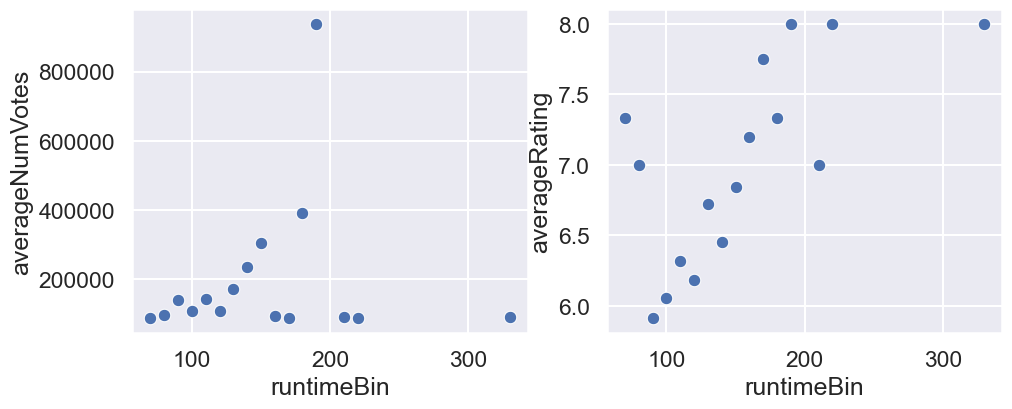

In [66]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # DO NOT MODIFY THIS LINE
sns.scatterplot(data=query_q4.DataFrame(), x='runtimeBin', y='averageNumVotes',)
plt.subplot(1, 2, 2) # DO NOT MODIFY THIS LINE
sns.scatterplot(data=query_q4.DataFrame(), x='runtimeBin', y='averageRating')

<!-- END QUESTION -->

<br/><br/>

---

## Question 5


Which **movie actors** have the highest average ratings across all the movies in which they star? Again, define **"movie actor"** as anyone with an `actor` or `actress` job category role in a `movie` title type.

Construct a query that generates a resulting table consisting of the **movie actor's name**  (as `name`) and their **average actor rating** (as `actorRating`) computed by rescaling ratings for movies in which they had a role:

$$
\text{actorRating} = 
\frac{\sum_m (\text{averageRating}[m] * \text{numVotes}[m] )}{\sum_m \text{numVotes}[m]}
$$

In addition, only consider ratings where there are **at least 1000** votes and only consider movie actors that have **at least 20 rated performances**. Present the movie actors with the **top 10** `actorRating` in descending order and break ties alphabetically using the movie actor's name.

**Note:** DO NOT cast `averageRating` **as an integer**. Doing so reduces the precision of the resulting values, so your table may not match up exactly with what is shown below.

The results should look something like this but without the `????`, and with higher rating precision.

| name | actorRating |
|-----:|:-----|
|????|8.4413...|
|????|8.2473...|
|????|8.1383...|
|????|8.1339...|
|????|8.0349...|
|????|7.9898...|
|????|7.9464...|
|????|7.9330...|
|????|7.9261...|
|????|7.8668...|


**Note**:
* ***The query should take < 3 minutes to run.***
* If an actor/actress has multiple `role` listings for a movie, then that movie will have a bigger impact on the overall average (this is desired).

In [75]:
%%sql  query_q5  <<
SELECT n.primaryName AS name, SUM(averageRating * numVotes) / SUM(numVotes) AS actorRating
FROM Name n
    INNER JOIN Role r ON n.nconst=r.nconst
    INNER JOIN Title t ON t.tconst=r.tconst
    INNER JOIN Rating on t.tconst=Rating.tconst
WHERE r.category IN ('actor','actress')
    AND t.titleType='movie'
    AND Rating.numVotes > 1000
GROUP BY name
HAVING COUNT(*) >= 20
ORDER BY actorRating DESC LIMIT 10;

Running query in 'sqlite:///data/imdbmini.db'

Congratulation for finishing Lab 6!



## Submission

Make sure you have run all cells in your notebook , so that all images/graphs appear in the output. 

